In [1]:
import importlib
from typing import Sequence
from datasets.dataset_dict import DatasetDict
import fire
import datasets
import sys

sys.path.append("/home/meissner/shortcut-pruning")
import numpy as np
from transformers import AutoTokenizer
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm import tqdm
import torch 
from matplotlib import pyplot as plt
from src.models.hf_model import SequenceClassificationTransformer
from src.models.hf_model_pruned import PruningTransformer

import torch 
from transformers import AutoModelForSequenceClassification
from nn_pruning.patch_coordinator import ModelPatchingCoordinator
from nn_pruning.modules.masked_nn import MaskedLinear

In [2]:
model = PruningTransformer.load_from_checkpoint("/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/pruning/vanilla_then_prune/runs/2022-05-24/11-35-12/checkpoints/last.ckpt").eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
original_model = SequenceClassificationTransformer.load_from_checkpoint("/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/baselines/bert/mnli/multiruns/2022-04-18/13-07-56/4/checkpoints/last.ckpt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
torch.allclose(original_model.model.encoder.layer[0].attention.self.query.weight, model.model.encoder.layer[0].attention.self.query.weight)

True

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mpc = ModelPatchingCoordinator(
#     sparse_args=sparse_args, 
#     device=device,
#     cache_dir="checkpoints", 
#     logit_names="logits",
#     teacher_constructor=None)

In [6]:
# return self.topk_mask(
#     self.context_module.mask_scores,
#     ampere_temperature,
#     self.training,
# )

In [23]:
model

PruningTransformer(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): MaskedLinear(
                (mask_module): MaskModule(
                  (context_modules): ModuleList(
                    (0): BlockLinearPruningContextModule()
                  )
                )
              )
              (key): MaskedLinear(
                (mask_module): MaskModule(
                  (context_modules): ModuleList(
                    (0): BlockLinearPruningContextModule()
                  )
                )
              )


In [60]:
modules = {}; masks = {}
for name, module in model.named_modules():
    if type(module) == MaskedLinear:
        modules[name] = module
        masks[name] = module.mask_module(module.weight, 0.85).detach().numpy()

In [7]:
modules = {}; masks = {}
for name, module in model.named_modules():
    if "mask" in name:
        modules[name] = module
        # masks[name] = module.mask_module(module.weight, 0.85).detach().numpy()

In [8]:
modules

{'model.encoder.layer.0.attention.self.query.mask_module': MaskModule(
   (context_modules): ModuleList(
     (0): BlockLinearPruningContextModule()
   )
 ),
 'model.encoder.layer.0.attention.self.query.mask_module.context_modules': ModuleList(
   (0): BlockLinearPruningContextModule()
 ),
 'model.encoder.layer.0.attention.self.query.mask_module.context_modules.0': BlockLinearPruningContextModule(),
 'model.encoder.layer.0.attention.self.key.mask_module': MaskModule(
   (context_modules): ModuleList(
     (0): BlockLinearPruningContextModule()
   )
 ),
 'model.encoder.layer.0.attention.self.key.mask_module.context_modules': ModuleList(
   (0): BlockLinearPruningContextModule()
 ),
 'model.encoder.layer.0.attention.self.key.mask_module.context_modules.0': BlockLinearPruningContextModule(),
 'model.encoder.layer.0.attention.self.value.mask_module': MaskModule(
   (context_modules): ModuleList(
     (0): BlockLinearPruningContextModule()
   )
 ),
 'model.encoder.layer.0.attention.self.val

In [62]:
module = list(modules.values())[0]

In [68]:
module.mask_module.context_modules[0]

AttributeError: 'BlockLinearPruningContextModule' object has no attribute 'context_modules'

model.encoder.layer.0.attention.self.query


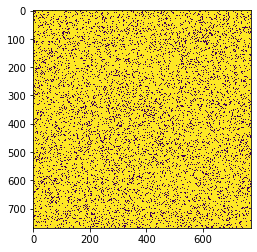

model.encoder.layer.0.attention.self.key


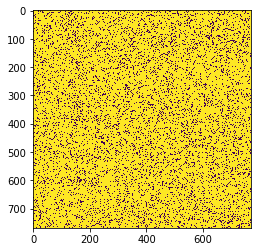

model.encoder.layer.0.attention.self.value


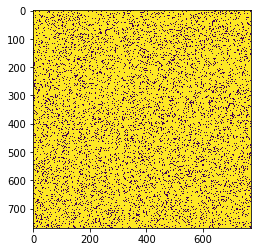

model.encoder.layer.0.attention.output.dense


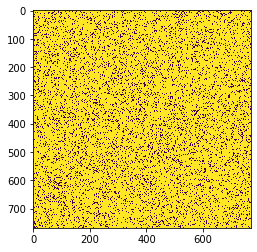

model.encoder.layer.0.intermediate.dense


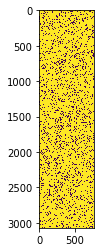

model.encoder.layer.0.output.dense


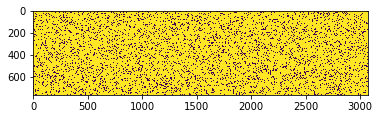

model.encoder.layer.1.attention.self.query


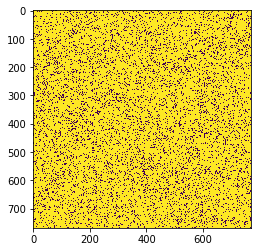

model.encoder.layer.1.attention.self.key


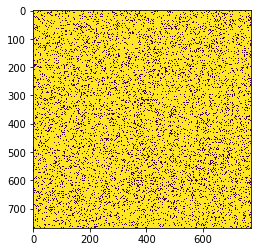

model.encoder.layer.1.attention.self.value


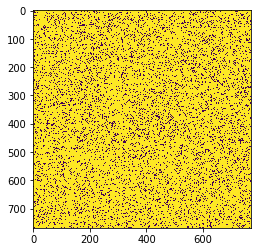

model.encoder.layer.1.attention.output.dense


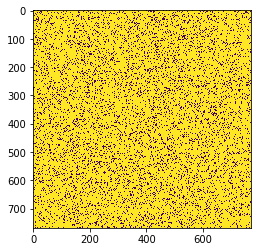

model.encoder.layer.1.intermediate.dense


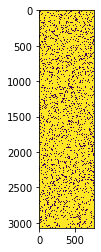

model.encoder.layer.1.output.dense


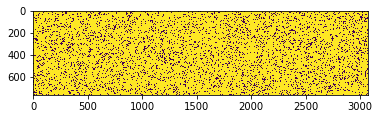

model.encoder.layer.2.attention.self.query


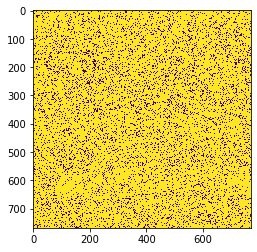

model.encoder.layer.2.attention.self.key


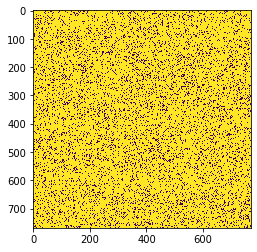

model.encoder.layer.2.attention.self.value


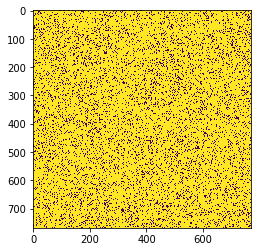

model.encoder.layer.2.attention.output.dense


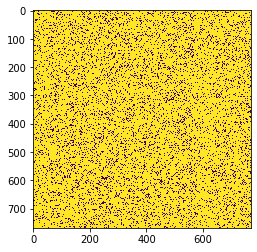

model.encoder.layer.2.intermediate.dense


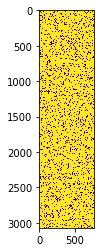

model.encoder.layer.2.output.dense


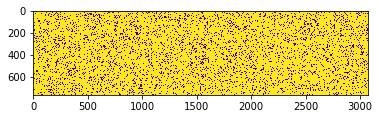

model.encoder.layer.3.attention.self.query


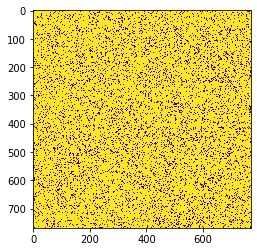

model.encoder.layer.3.attention.self.key


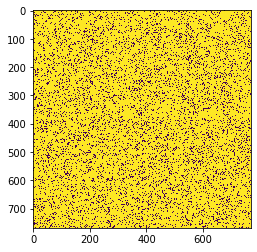

model.encoder.layer.3.attention.self.value


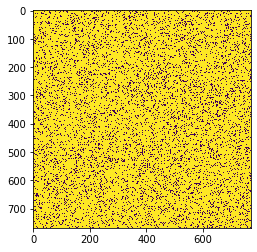

model.encoder.layer.3.attention.output.dense


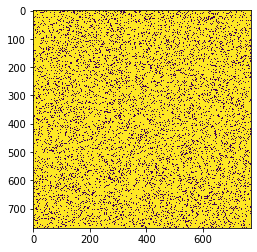

model.encoder.layer.3.intermediate.dense


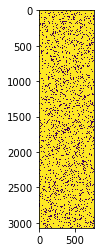

model.encoder.layer.3.output.dense


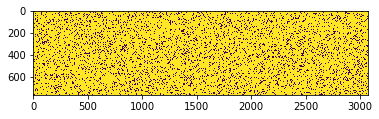

model.encoder.layer.4.attention.self.query


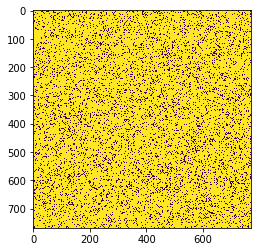

model.encoder.layer.4.attention.self.key


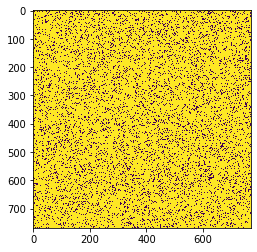

model.encoder.layer.4.attention.self.value


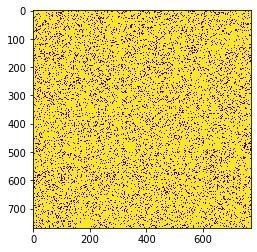

model.encoder.layer.4.attention.output.dense


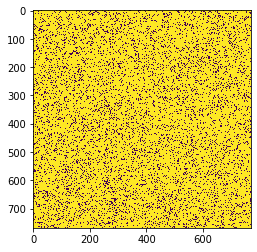

model.encoder.layer.4.intermediate.dense


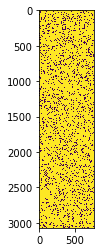

model.encoder.layer.4.output.dense


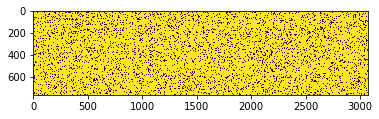

model.encoder.layer.5.attention.self.query


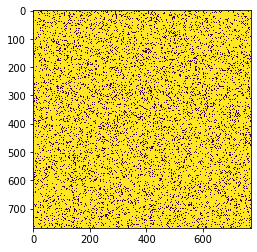

model.encoder.layer.5.attention.self.key


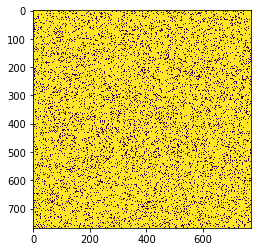

model.encoder.layer.5.attention.self.value


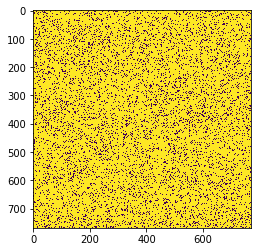

model.encoder.layer.5.attention.output.dense


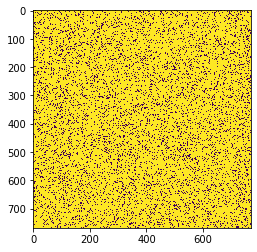

model.encoder.layer.5.intermediate.dense


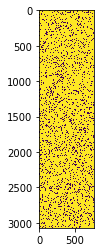

model.encoder.layer.5.output.dense


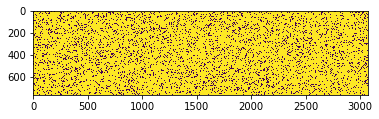

model.encoder.layer.6.attention.self.query


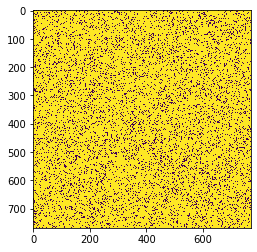

model.encoder.layer.6.attention.self.key


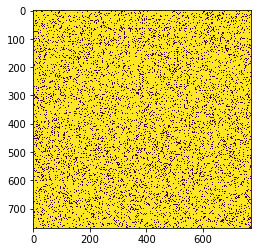

model.encoder.layer.6.attention.self.value


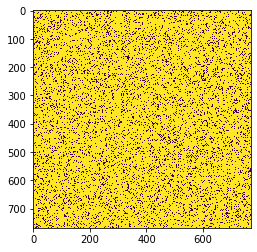

model.encoder.layer.6.attention.output.dense


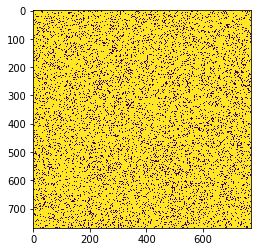

model.encoder.layer.6.intermediate.dense


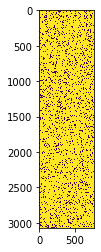

model.encoder.layer.6.output.dense


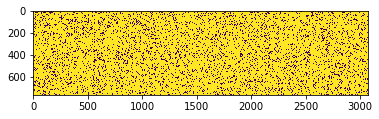

model.encoder.layer.7.attention.self.query


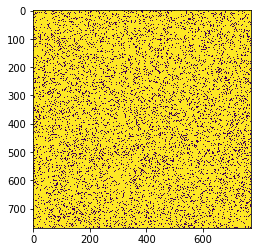

model.encoder.layer.7.attention.self.key


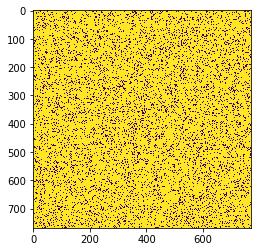

model.encoder.layer.7.attention.self.value


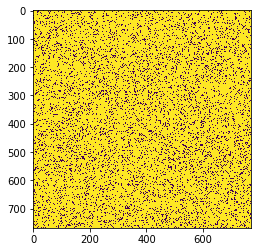

model.encoder.layer.7.attention.output.dense


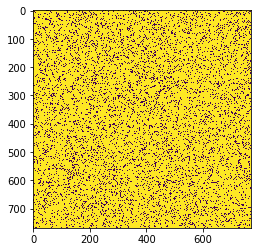

model.encoder.layer.7.intermediate.dense


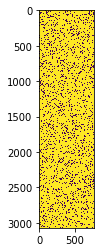

model.encoder.layer.7.output.dense


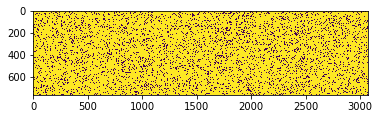

model.encoder.layer.8.attention.self.query


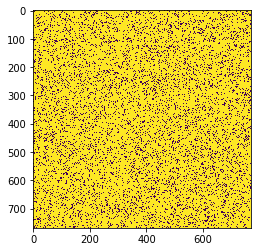

model.encoder.layer.8.attention.self.key


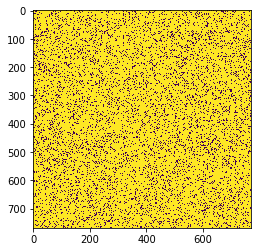

model.encoder.layer.8.attention.self.value


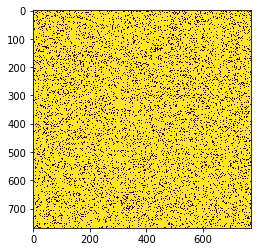

model.encoder.layer.8.attention.output.dense


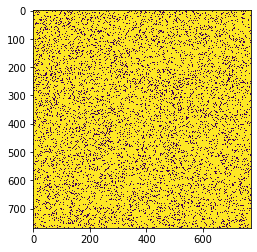

model.encoder.layer.8.intermediate.dense


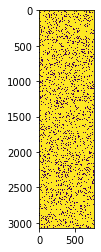

model.encoder.layer.8.output.dense


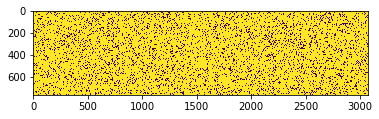

model.encoder.layer.9.attention.self.query


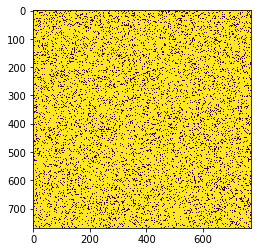

model.encoder.layer.9.attention.self.key


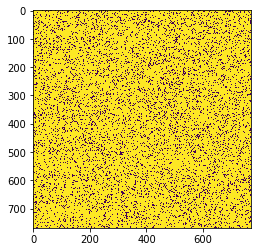

model.encoder.layer.9.attention.self.value


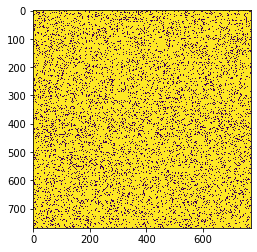

model.encoder.layer.9.attention.output.dense


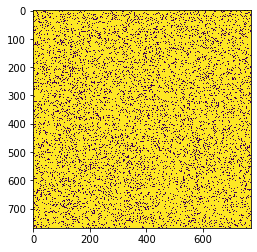

model.encoder.layer.9.intermediate.dense


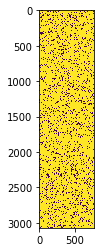

model.encoder.layer.9.output.dense


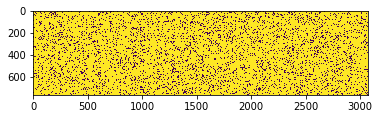

model.encoder.layer.10.attention.self.query


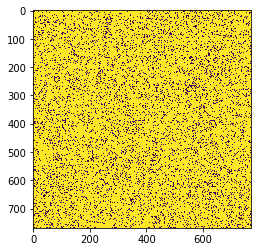

model.encoder.layer.10.attention.self.key


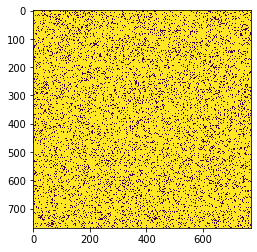

model.encoder.layer.10.attention.self.value


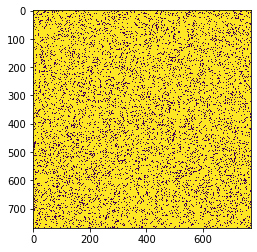

model.encoder.layer.10.attention.output.dense


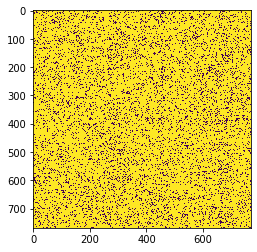

model.encoder.layer.10.intermediate.dense


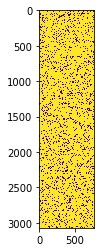

model.encoder.layer.10.output.dense


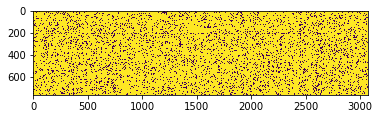

model.encoder.layer.11.attention.self.query


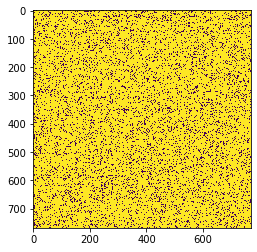

model.encoder.layer.11.attention.self.key


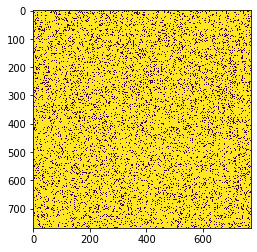

model.encoder.layer.11.attention.self.value


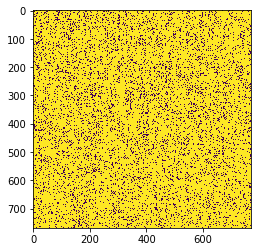

model.encoder.layer.11.attention.output.dense


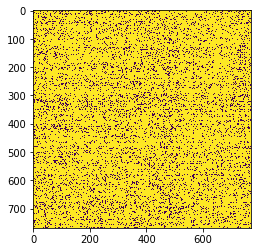

model.encoder.layer.11.intermediate.dense


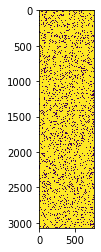

model.encoder.layer.11.output.dense


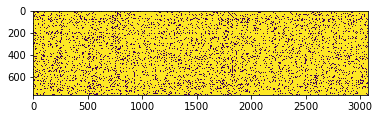

In [44]:
for name, mask in masks.items():
    print(name)
    plt.imshow(mask, interpolation="none")
    plt.show()